In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from skimage.io import imread

# Первая часть
### Задание 1

In [2]:
def load_dataset(shuffle=False):
    preloaded = load_digits()
    dataset = preloaded.data
    labels = preloaded.target
 
    if shuffle:
        stacked = np.hstack((dataset, labels.reshape(labels.shape[0], 1)))
        np.random.shuffle(stacked)
        dataset = stacked[:, :-1]
        labels = stacked[:, -1].astype(np.int)
 
    return dataset, labels

X, y = load_dataset(shuffle=True)

### Задания 2 - 3

In [3]:
def run_kmeans(init, X, y, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, init=init, copy_x=True)
    predicted_labels = kmeans.fit_predict(X)
    
    amis = adjusted_mutual_info_score(y, predicted_labels)
    ars = adjusted_rand_score(y, predicted_labels)
    
    print "Adjusted mutual info score using init=%s equals %s" % (str(init), str(amis))
    print "Adjusted random score using init=%s equals %s" % (str(init), str(ars))
    
    return kmeans

def visualize_centroids(kmeans):
    figure = 1
    images = kmeans.cluster_centers_
    for image in images:
        plt.figure(figure)
        figure += 1
        plt.imshow(image.reshape(8,8))
        plt.show()

In [4]:
kmeans1 = run_kmeans('k-means++', X, y)

Adjusted mutual info score using init=k-means++ equals 0.732777012963
Adjusted random score using init=k-means++ equals 0.663502519906


In [5]:
kmeans2 = run_kmeans('random', X, y)

Adjusted mutual info score using init=random equals 0.731902196608
Adjusted random score using init=random equals 0.646814473317


Adjusted Random Score при разных инициализаторах получился ниже, чем Adjusted Mutual Info Score, так что можно говорить о корреляции. Кроме того, значения примерно равны для обоих метрик в обоих случаях

### Задание 4

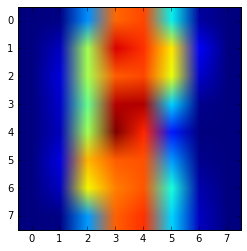

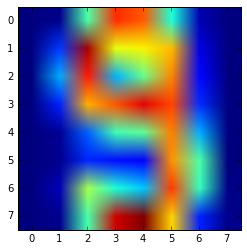

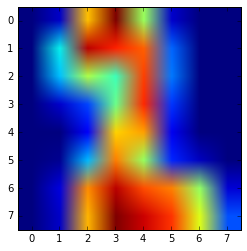

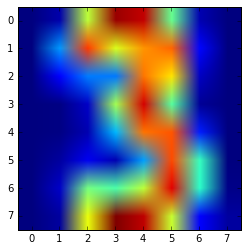

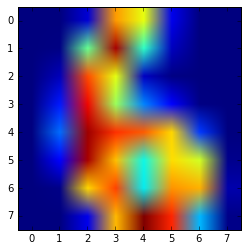

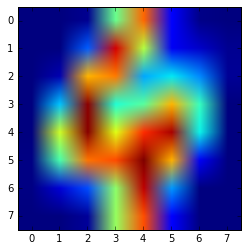

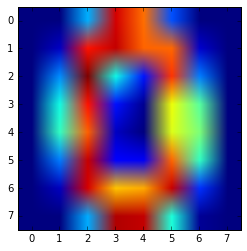

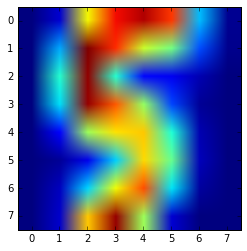

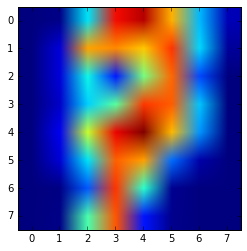

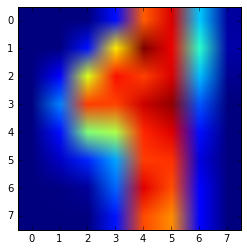

In [6]:
visualize_centroids(kmeans1)

### Задание 5

In [8]:
pca = PCA(n_components=10)
reduced_X = pca.fit_transform(X)
test = KMeans(n_clusters=11, copy_x=True)
predicted = test.fit_predict(reduced_X)

amis = adjusted_mutual_info_score(y, predicted)
ars = adjusted_rand_score(y, predicted)
    
print "Adjusted mutual info score equals %s" % str(amis)
print "Adjusted random score equals %s" % str(ars)

# TODO доделать

Adjusted mutual info score equals 0.732239749477
Adjusted random score equals 0.688445793917


# Вторая часть

### Задание 1

In [71]:
parrots = imread('parrots.jpg')

### Задания 2-3

In [72]:
def cluster_image(image_array, n_clusters=8):
    kmeans = KMeans(n_clusters=n_clusters, copy_x=True).fit(image_array)
    return kmeans
    
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

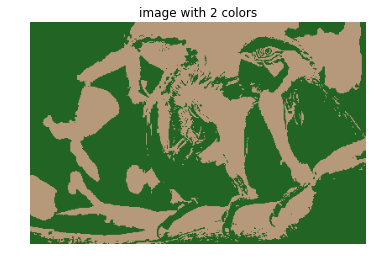

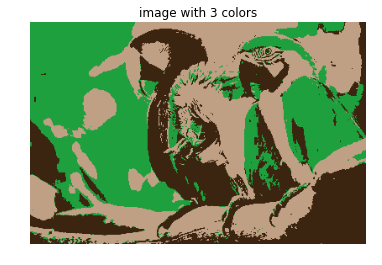

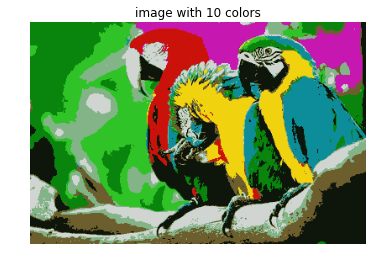

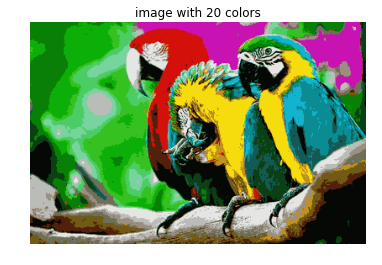

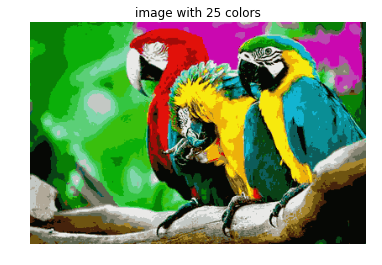

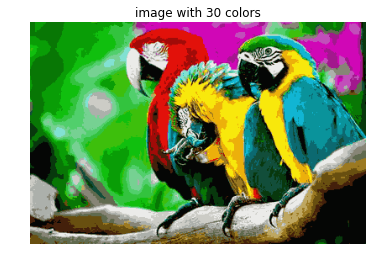

In [75]:
# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1]
image_array = np.array(parrots, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(image_array.shape)
image_array = np.reshape(image_array, (w * h, d))

image_array_sample = shuffle(image_array, random_state=42)[:25000]

fignum = 1
n_colors = 10
clnums = [2, 3, 10, 20, 25, 30]
for n_colors in clnums:
    kmeans = cluster_image(image_array, n_clusters=n_colors)
    labels = kmeans.predict(image_array)
    
    plt.figure(fignum)
    plt.clf()
    plt.axis('off')
    plt.title('image with %s colors' % str(n_colors))
    plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))
    plt.show()
    
    fignum += 1


### Задание 4
Картинка с числом кластеров 20 уже выглядит приемлимо.

# Третья часть
### Задание 1

In [24]:
grass = imread('grass.jpg')

### Задания 2 - 4

In [3]:
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering

In [4]:
def segment(img, N_REGIONS, coeff):
    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1]
    image_array = np.array(img, dtype=np.float64) / 255
    w, h, d = original_shape = tuple(image_array.shape)
    
    space = transform_space(image_array, coeff)
    space = space.reshape((w * h, 5))
    
    kmeans = KMeans(n_clusters=N_REGIONS, copy_x=True)
    kmeans.fit(space)
    
    labels = kmeans.predict(space)
    labels = labels.reshape(w, h)
    
    return labels

def transform_space(img, coeff):
    height = img.shape[0]
    width = img.shape[1]
    space = np.empty((height, width, 5))
    
    for i in range(0, height):
        for j in range(0, width):
            r = img[i][j][0]
            g = img[i][j][1]
            b = img[i][j][2]
            space[i][j] = np.array([coeff*i, coeff*j, r, g, b])
            
    return space

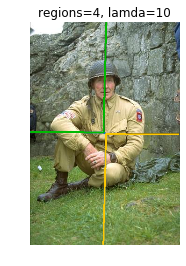

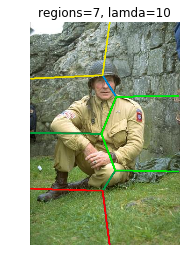

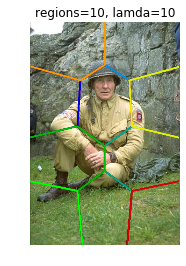

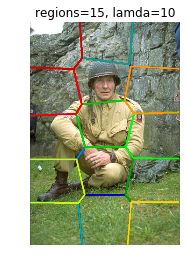

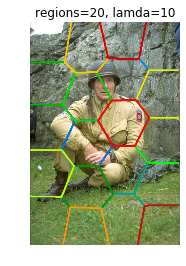

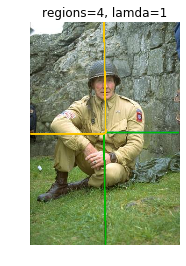

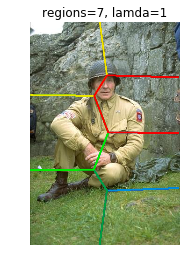

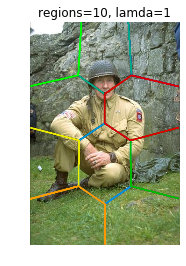

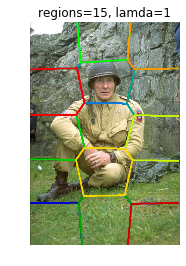

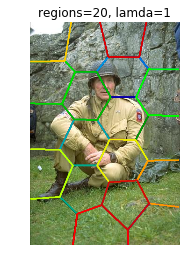

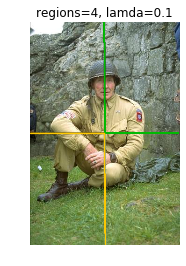

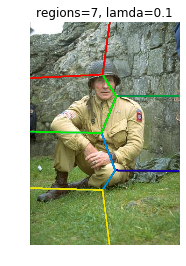

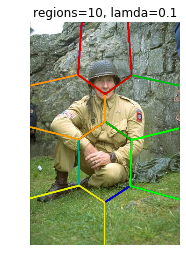

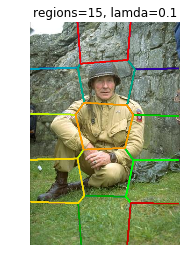

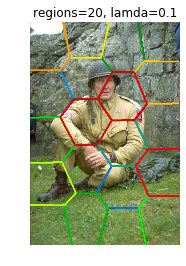

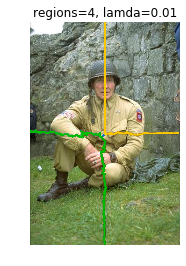

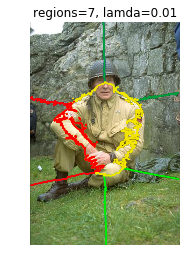

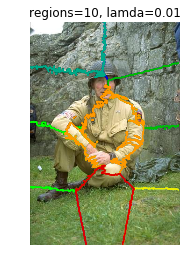

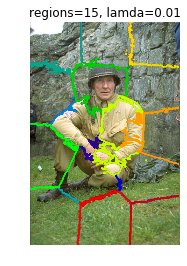

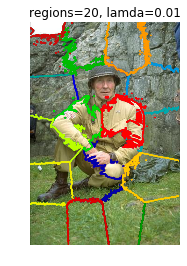

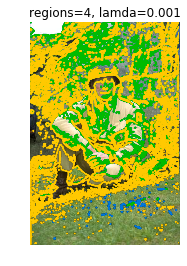

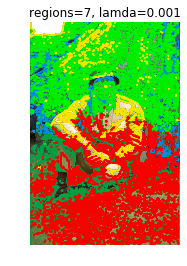

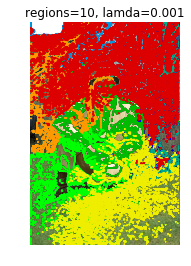

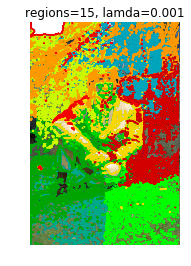

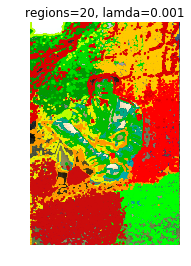

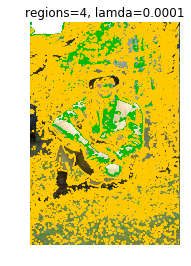

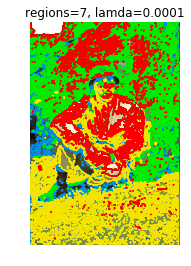

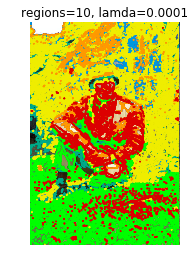

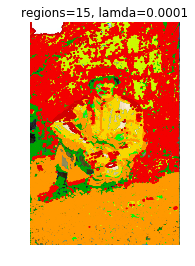

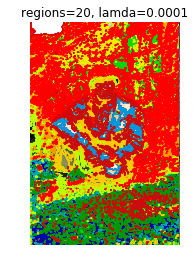

In [176]:
coeffs = [10, 1, 0.1, 0.01, 0.001, 0.0001]
regions = [4, 7, 10, 15, 20]
fignum = 0
for coeff in coeffs:
    for region in regions:
        labels = segment(grass, region, coeff)
        fignum += 1
        plt.figure(fignum)
        plt.imshow(grass)
        plt.title('regions=%s, lamda=%s' % (region, coeff))
        plt.axis('off')
        for l in range(region):
            plt.contour(labels == l, contours=1, 
                colors=[plt.cm.spectral(l / float(region)), ])
            
        plt.show()

Лучше всего сегментация выглядит при наборе параметров (region=4, lamda=0.001). При большой(>0.01) lambda сегментация практически не имеет эффекта.

### Задания 5-7

In [108]:
def run_spectral_clustering(img, assign_labels, N_REGIONS):
    
    # Convert the image into a graph with the value of the gradient on the
    # edges.
    graph = image.img_to_graph(img)
    
    # Take a decreasing function of the gradient: an exponential
    # The smaller beta is, the more independant the segmentation is of the
    # actual image. For beta=1, the segmentation is close to a voronoi
    beta = 5
    eps = 1e-6
    graph.data = np.exp(-beta * graph.data / img.std()) + eps
    
    labels = spectral_clustering(graph, n_clusters=N_REGIONS, 
                                 assign_labels=assign_labels, 
                                 eigen_solver='amg')
    labels = labels.reshape(img.shape)
    
    return labels
    
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [109]:
asl = ['kmeans', 'discretize']
region_count = [4, 7, 10, 15, 20, 40, 60]

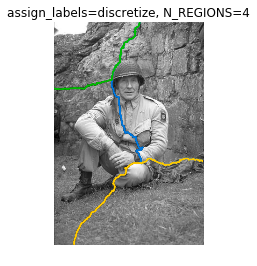

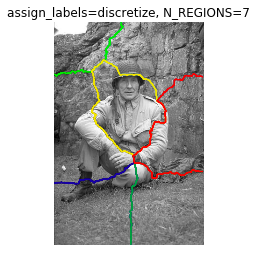

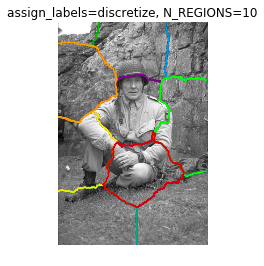

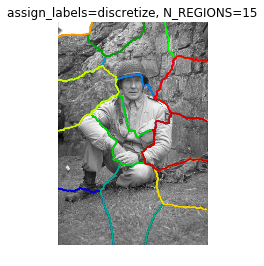

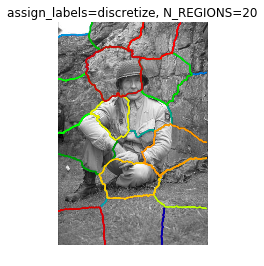

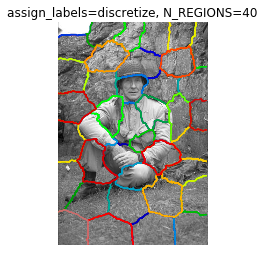

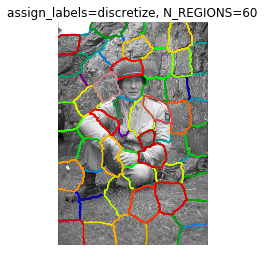

In [110]:
grass_gs = rgb2gray(grass)
fignum = 0
for assign_labels in asl:
    for N_REGIONS in region_count:
        fignum += 1
        labels = run_spectral_clustering(grass_gs, 
                                         assign_labels, 
                                         N_REGIONS)
        ###########################################################
        # Visualize the resulting regions
        plt.figure(fignum)
        plt.title('assign_labels=%s, N_REGIONS=%s' % (assign_labels, 
                                                      N_REGIONS))
        plt.imshow(grass_gs, cmap=plt.cm.gray)
        for l in range(N_REGIONS):
            plt.contour(labels == l, contours=1,
                colors=[plt.cm.spectral(l / float(N_REGIONS)), ])
        plt.axis('off')
        plt.show()
        

Discretize работал быстрее и выдал более понятые глазу изображения, где относительно точно обведены контуры (например, лицо)